# Exercises

## Exercise 1

Which Linear Regression algorithm can you use if you have a training set with millions of features?

---

Any of the gradient descent algorithms (batch, stochastic, mini-batch) will be relatively fast.

## Exercise 2

Suppose the features in your training set have very different scales. Which algorithms suffer from this, and how? What can you do about this?

---

The gradient descent algorithms suffer from this. Essentially, the learning rate is the same in all directions, so if the features have very different scales then it can't be set appropriately for all of them. It will either quickly converge on one axis and then crawl along a valley, or will jump around wildly on one axis.

This can easily be resolved by feature scaling before training.

*Also, regularisation may converge to suboptimal weights, since regularisation penalises large weights, features with smaller values will tend to be ignored.*

## Exercise 3

Can Gradient Descent algorithms get stuck in a local minimum with training a Logistic Regression model.

---

No, the Logistic Regression cost function is convex.

## Exercise 4

Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?

---

Yes, provided that the learning rates are set such that the training algorithms converge.

## Exercise 5

Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?

---

If the validation error is consistently going up then the algorithm is likely not converging because the learning rate is too high - with each step you are 'jumping over' the minimum instead of getting closer. You can fix this by decreasing the learning rate.

## Exercise 6

Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?

---

No. Mini-batch is naturally stochastic - it may go in the wrong direction for a step or two but later improve. You should let the algorithm run fully to find the global minimum for validation error.

## Exercise 7

Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution fastest? Which will actually converge? How can you make the others converge as well?

---

Batch will reach the vicinity of the optimal solution in the fewest number of *steps*, but each step will take longer to compute. After computation time is taken into account, I expect that mini-batch would be fastest. *(It would be stochastic gradient descent or mini-batch with very small mini-batch size)*

Only batch gradient descent will actually converge, but you can make stochastic and mini-batch converge by setting a suitable learning schedule that decreases the learning rate.

## Exercise 8

Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?

---

You are overfitting the training data. You could solve this by reducing the degree of the polynomials (simplifying the model), adding or increasig regularisation, or getting more training data.

## Exercise 9

Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularisation parameter $\alpha$ or reduce it?

---

If the training and validation error are very similar then you are underfitting the training data so you have high *bias*. You should reduce the regularisation parameter $\alpha$.

## Exercise 10

Why would you want to use:
1. Ridge Regression instead of plain Linear Regression?
2. Lasso instead of Ridge Regression?
3. Elastic Net instead of Lasso?

---

1. Ridge Regression allows you to apply regularisation which reduces overfitting.
2. Lasso tends to set coefficients equal to zero which performs feature selection as well as regularisation. This leads to a sparser model (which is generally perferred).
3. Lasso tends to behave strangely when there are more features than training samples or when several features are strongly correlated. Also, Lasso is a special case of Elastic net at a specific hyperparameter value - adding this additional hyperparameter can only decrease validation error.

## Exercise 11

Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?

---

Two logistic regression classifiers. Softmax regression is for multiclass classification, not multioutput.

## Exercise 12

Implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn).

---

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Functions that will be needed for gradient descent - cost function, gradient, prediction function etc.

In [2]:
def add_bias(X):
    "Add bias column or single value to X"
    if len(X.shape) == 1:
        X_b = np.append([1], X)

    elif len(X.shape) == 2:
        n_sample = X.shape[0]
        bias = np.ones((n_sample, 1))
        X_b = np.append(bias, X, axis=1)

    return X_b


def one_hot_encode(y):
    "Turn array with values 0,..,n_class-1 into 01 matrix of shape (n_sample, n_class)"
    n_sample = len(y)
    n_class = len(np.unique(y))

    Y = np.zeros((n_sample, n_class))
    Y[np.arange(n_sample), y] = 1

    return Y


def softmax(X_b, params):
    "Applies softmax function to vector/matrix input with bias"
    P = np.exp((X_b @ params.T))

    if len(X_b.shape) == 1:
        P /= P.sum()

    elif len(X_b.shape) == 2:
        P /= np.c_[P.sum(axis=1)]

    return P


def softmax_predict(X_b, params):
    "Use softmax for prediction - take class with greatest value"
    P = softmax(X_b, params)

    if len(X_b.shape) == 1:
        return np.argmax(P)

    elif len(X_b.shape) == 2:
        return np.argmax(P, axis=1)


def softmax_misclassification_error(X, y, params):
    "Misclassification error using softmax for prediction"
    X_b = add_bias(X)
    y_pred = softmax_predict(X_b, params)

    err = (y != y_pred).sum() / len(y)

    return err


def cross_entropy(X_b, Y, params):
    "Cross entropy cost function"
    n_sample = X_b.shape[0]

    P = softmax(X_b, params)

    J = -np.trace(Y.T @ np.log(P))
    J /= n_sample

    return J


def cross_entropy_gradient(X_b, Y, params):
    "Gradient of cross entropy cost function"
    n_sample = X_b.shape[0]

    P = softmax(X_b, params)

    grad = (P - Y).T @ X_b / n_sample

    return grad

Gradient descent function and plotting training and validation errors.

In [3]:
def train_val_split(X, y, val_prop):
    n_sample = len(y)

    train_prop = 1 - val_prop
    n_train = int(n_sample * train_prop)

    X_train, y_train = X[:n_train], y[:n_train]
    X_val, y_val = X[n_train:], y[n_train:]

    return X_train, X_val, y_train, y_val


def softmax_gradient_descent(
    X,
    y,
    learning_rate=0.1,
    n_iter=100,
    params_init=None,
    val_prop=0.2,
    early_stopping_rounds=None,
):
    """
    Batch gradient descent for softmax regression with option of early stopping.

    Inputs
    ------
    n_iter: maximum number of iterations
    params_init: initial value of parameters - default is all zeros
    val_prop: proportion of instances to use for validation
    early_stopping_rounds:
        if set, gradient descent will stop after misclassification error on validation set
        doesn't decrease for this number of iterations

    Outputs
    -------
    iter_best:
        the iteration that last made validation error decrease (for early stopping)
        if no early stopping, this is just the total number of iterations
    params_best:
        the params that last made validation error decrease (for early stopping)
        if no early stopping, these are just the final values
    params: array of all parameter values
    train_err: array of training error at each iterationn
    val_err: array of validation error at each iterationn
    """
    n_class = len(np.unique(y))
    n_sample, n_feat = X.shape

    # initial value of parameters
    if type(params_init) is not np.ndarray:
        params_init = np.zeros((n_class, n_feat + 1))

    params = params_init

    # split into training and validation sets
    X_train, X_val, y_train, y_val = train_val_split(X, y, val_prop)

    # record errors and parameter values in arrays
    params_array = np.array([params])
    train_err = np.array([softmax_misclassification_error(X_train, y_train, params)])
    val_err = np.array([softmax_misclassification_error(X_val, y_val, params)])

    # prepare training data for calculating cross entropy gradient
    Xb_train = add_bias(X_train)
    Y_train = one_hot_encode(y_train)

    # count how many rounds the validation error has gone w/o decreasing and store values from last decrease
    # (if no early stopping these are always the most recent values and n_incr=0)
    iter_best = 0
    params_best = params
    n_incr = 0

    for iter in range(n_iter):
        # gradient descent step
        grad = cross_entropy_gradient(Xb_train, Y_train, params)
        params -= learning_rate * grad

        # record new params and errors
        params_array = np.append(params_array, [params], axis=0)

        err = softmax_misclassification_error(X_train, y_train, params)
        train_err = np.append(train_err, err)

        err = softmax_misclassification_error(X_val, y_val, params)
        val_err = np.append(val_err, err)

        if early_stopping_rounds and val_err[-1] >= val_err[-2]:
            # if error doesn't decrease, increase counter and break if it exceeds limit
            n_incr += 1

            if n_incr >= early_stopping_rounds:
                print("Early stopping after {} iterations".format(iter + 1))
                print("Best iteration: {}".format(iter_best))
                break

        # if error decreases, reset increase counter and record new best values
        else:
            iter_best = iter + 1
            params_best = params
            n_incr = 0

    return iter_best, params_best, params_array, train_err, val_err


def plot_train_val_errors(train_err, val_err, xmin=0, ax=None, title=None):
    """
    Plot training and validation errors.
    You can set min value of 'iter' since this is very high for low values.
    You can either feed in an axis, or it will create a new plot.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=(18, 12))

    ax.plot(train_err[xmin:], label="Training Error")
    ax.plot(val_err[xmin:], label="Validation Error")

    ax.axhline(val_err.min(), ls=":", color="k", label="Minimum")

    ax.set_ylim(bottom=0)

    ax.set_xlabel("Iterations")
    ax.set_ylabel("Misclassification Error")

    if not title:
        title = "Error Against Iterations in SoftMax Gradient Descent"

    ax.set_title(title)

    ax.legend()

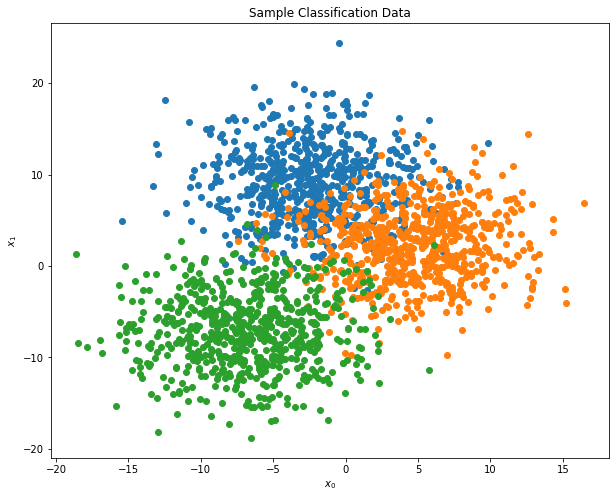

In [4]:
# generate sample data
from sklearn.datasets import make_blobs

X, y = make_blobs(
    n_samples=2000,
    n_features=2,
    centers=3,
    cluster_std=4.0,
    shuffle=True,
    random_state=42,
)


def plot_sample_data(X, y):
    fig, ax = plt.subplots(figsize=(10, 8))

    for k in np.unique(y):
        ax.scatter(X[y == k, 0], X[y == k, 1])

    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

    ax.set_title("Sample Classification Data")


plot_sample_data(X, y);

Early stopping after 66 iterations
Best iteration: 56


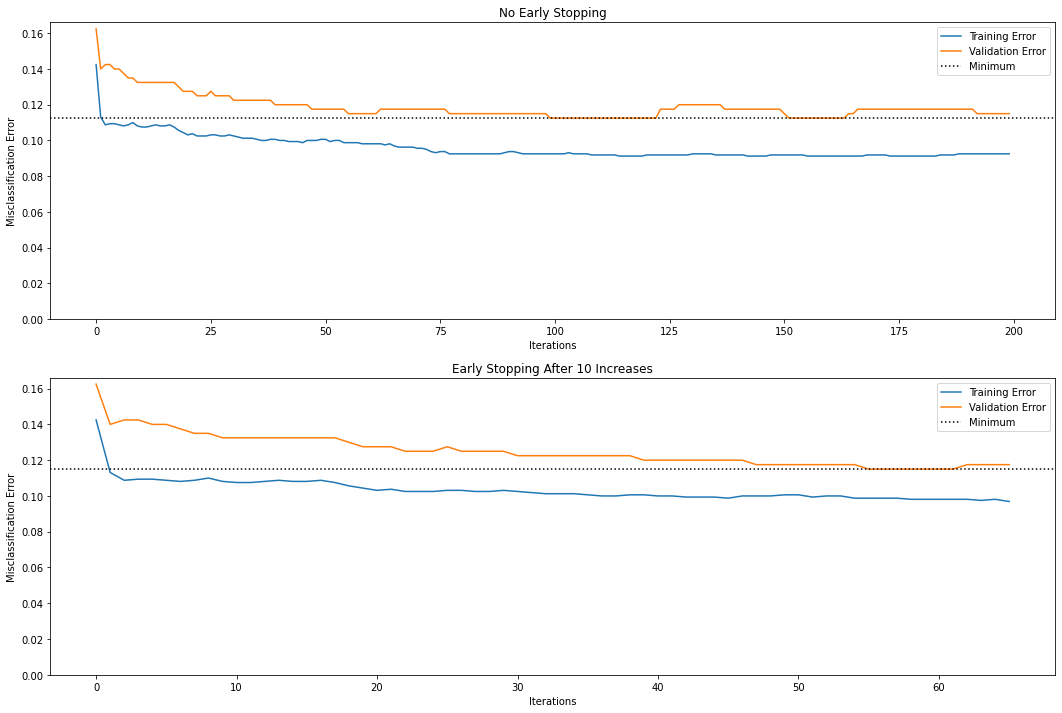

In [5]:
# params
learning_rate = 0.2
n_iter = 200
params_init = None
val_prop = 0.2

# plot training and validation errors for early stopping and no early stopping
fig, axs = plt.subplots(2, 1, figsize=(18, 12))

iter_best, params_best, params_array, train_err, val_err = softmax_gradient_descent(
    X,
    y,
    learning_rate=learning_rate,
    n_iter=n_iter,
    params_init=params_init,
    val_prop=val_prop,
    early_stopping_rounds=None,
)
plot_train_val_errors(train_err, val_err, xmin=1, ax=axs[0], title="No Early Stopping")

iter_best, params_best, params_array, train_err, val_err = softmax_gradient_descent(
    X,
    y,
    learning_rate=learning_rate,
    n_iter=n_iter,
    params_init=params_init,
    val_prop=val_prop,
    early_stopping_rounds=10,
)
plot_train_val_errors(
    train_err, val_err, xmin=1, ax=axs[1], title="Early Stopping After 10 Increases"
)

Note that early stopping didn't actually find the smallest validation error.

In [6]:
print("Early stopping training error: {}".format(train_err[iter_best]))
print("Early stopping validation error: {}".format(val_err[iter_best]))

print("\nParameters")
print("----------")
print(params_best)

Early stopping training error: 0.09875
Early stopping validation error: 0.115

Parameters
----------
[[-0.3027076  -0.09896131  0.35326343]
 [ 0.52169183  0.4052103   0.03285046]
 [-0.21898423 -0.30624899 -0.38611388]]


Test against scikit-learn

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_val, y_train, y_val = train_val_split(X, y, val_prop)

log_clf = LogisticRegression(penalty="none", multi_class="multinomial")
log_clf.fit(X_train, y_train)

y_pred = log_clf.predict(X_train)
print("Training error: {}".format(1 - accuracy_score(y_train, y_pred)))

y_pred = log_clf.predict(X_val)
print("Validation error: {}".format(1 - accuracy_score(y_val, y_pred)))

sklearn_params = np.c_[log_clf.intercept_, log_clf.coef_]
print("\nParameters")
print("----------")
print(sklearn_params)

Training error: 0.09312500000000001
Validation error: 0.11499999999999999

Parameters
----------
[[-0.79912014 -0.08274678  0.4778157 ]
 [ 1.2679536   0.3976091   0.01231133]
 [-0.46883346 -0.31486232 -0.49012703]]


Errors are very similar and if we let our Softmax regression run longer it eventually reaches these values.